# SoG wind decomposition recipes

***

In [132]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from datetime import datetime
from salishsea_tools import viz_tools, places

%matplotlib inline

In [145]:
HRDPS = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaSurfaceAtmosphereFieldsV1')
mask = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSn3DMeshMaskV17-02')

stations = [
    {'name': 'Sentry Shoal' , 'angle': 12},
    {'name': 'Sisters Islet', 'angle': 35},
    {'name': 'Halibut Bank' , 'angle': 30},
    {'name': 'Sandheads'    , 'angle': 15},
    {'name': 'Central SJDF' , 'angle': 50},
]

timerange = [datetime(2020, 1, 1), datetime(2020, 1, 15)]
time = HRDPS.time.sel(time=slice(*timerange)).values.astype('datetime64[s]').astype(datetime)
l = 30

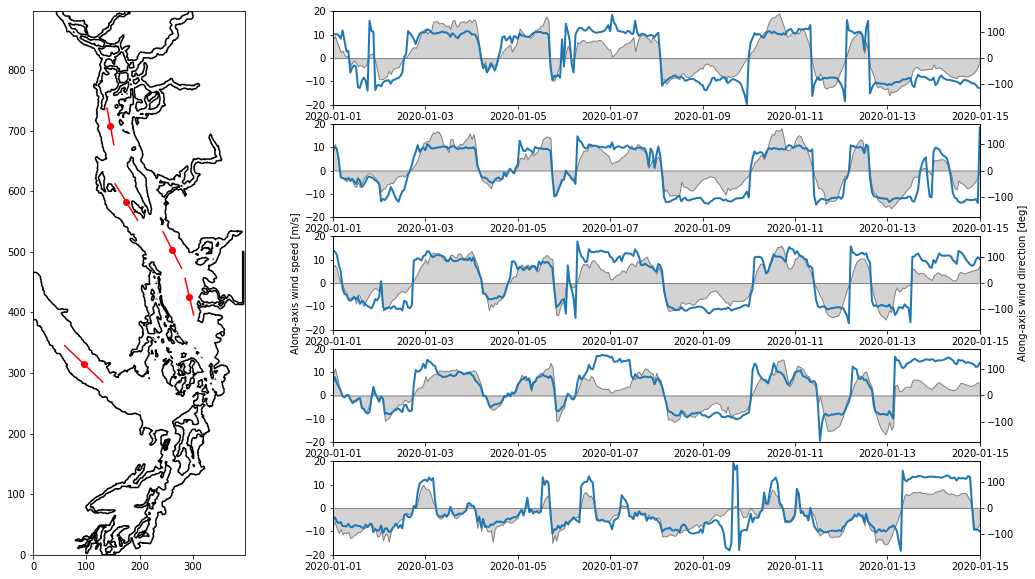

In [155]:
# Make plot area and map
fig = plt.figure(figsize=(17, 10))
gs = plt.GridSpec(5, 2, width_ratios=[1, 3])
ax_map = fig.add_subplot(gs[:, 0])
ax_map.contour(mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
viz_tools.set_aspect(ax_map)

# Loop through stations
for row, station in zip(range(6), stations):
    
    # Show points on map
    j, i = places.PLACES[station['name']]['NEMO grid ji']
    s = np.tan((station['angle'] + 90) * np.pi / 180)
    ax_map.plot(i, j, 'ro')
    ax_map.plot([i-l/s, i+l/s], [j-l, j+l], 'r-')
    
    # Calc wind record
    j, i = places.PLACES[station['name']]['GEM2.5 grid ji']
    u, v = [HRDPS[k].sel(time=slice(*timerange))[:, j, i].values for k in ['u_wind', 'v_wind']]
    angle = np.arctan2(v, u) - np.pi * (29 + station['angle']) / 180
    angle[angle < -np.pi] = angle[angle < -np.pi] + 2*np.pi
    mag = np.sin(angle) * np.sqrt(u**2 + v**2)
    
    # Plot wind speed record
    ax = fig.add_subplot(gs[row, 1])
    ax.fill_between(time, mag, facecolor='lightgray', edgecolor='gray')
    ax.set_xlim(timerange)
    ax.set_ylim([-20, 20])
    if row == 2: ax.set_ylabel('Along-axis wind speed [m/s]')
    if row < 4: ax.xaxis.set_ticklabels('')
    
    # Plot wind angle
    ax2 = ax.twinx()
    ax2.plot(time, angle * 180 / np.pi, linewidth=2)
    ax2.set_ylim([-180, 180])
    if row == 2: ax2.set_ylabel('Along-axis wind direction [deg]')